<a href="https://colab.research.google.com/github/samiha-mahin/An-Image-Processing-Repo/blob/main/Breast_Cancer_Classification_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Upload your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"3b6d29c9556db74812f31ee98a90662f"}'}

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset
License(s): CC0-1.0
100% 194M/195M [00:00<00:00, 663MB/s]  
100% 195M/195M [00:00<00:00, 696MB/s]


# **Load Dataset into DataFrame**

In [6]:
import numpy as np
import pandas as pd
import os
import cv2

In [7]:
base_path = "./data/Dataset_BUSI_with_GT"

categories = ["benign","malignant","normal"]

data = []

for label in categories:
    folder = os.path.join(base_path, label)
    for file in os.listdir(folder):
      if file.endswith(".png") and "_mask" not in file:
        data.append([os.path.join(folder,file),label])

df = pd.DataFrame(data, columns=["image_path","label"])
print("Dataset Shape:",df.shape)
df.head()

Dataset Shape: (780, 2)


,image_path,label
0,./data/Dataset_BUSI_with_GT/benign/benign (360...,benign
1,./data/Dataset_BUSI_with_GT/benign/benign (13)...,benign
2,./data/Dataset_BUSI_with_GT/benign/benign (383...,benign
3,./data/Dataset_BUSI_with_GT/benign/benign (97)...,benign
4,./data/Dataset_BUSI_with_GT/benign/benign (215...,benign


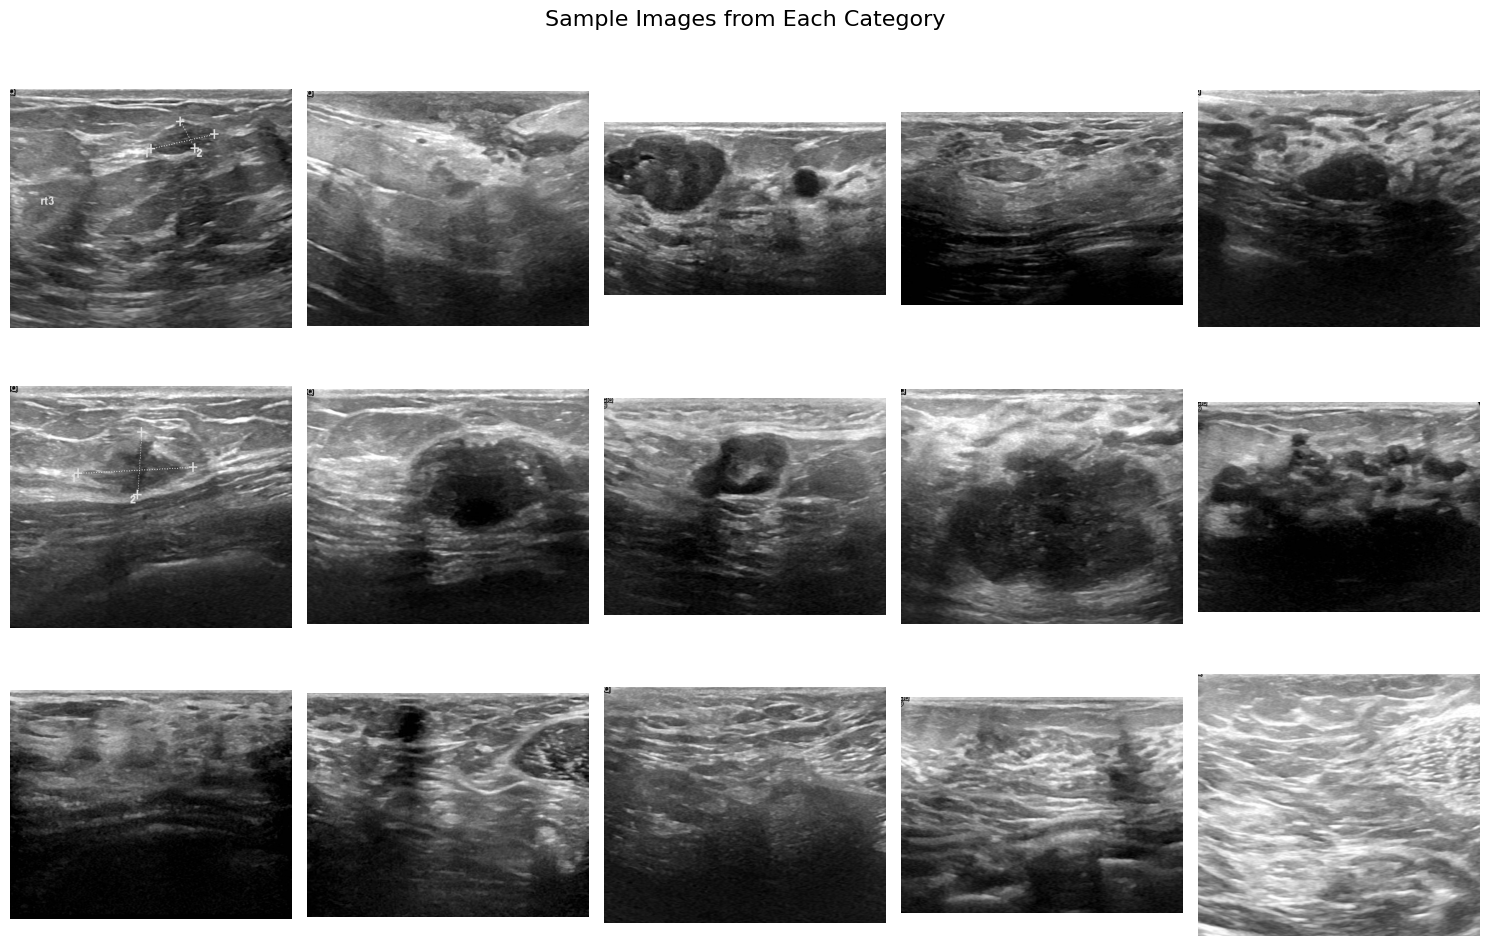

In [9]:
import matplotlib.pyplot as plt
import cv2

num_images = 5  # images per class

# Create the plot grid
fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))
fig.suptitle("Sample Images from Each Category", fontsize=16)

# Loop through each category
for i, category in enumerate(categories):
    images = df[df['label'] == category].sample(num_images, random_state=42)
    for j, path in enumerate(images['image_path']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(img)      # Show image
        axes[i, j].axis('off')      # Remove axes
    axes[i, 0].set_ylabel(category, fontsize=14)  # Label only first column

plt.tight_layout()
plt.show()


# **Visualize Data Distribution**

/tmp/ipython-input-718831597.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df ,palette='pastel')


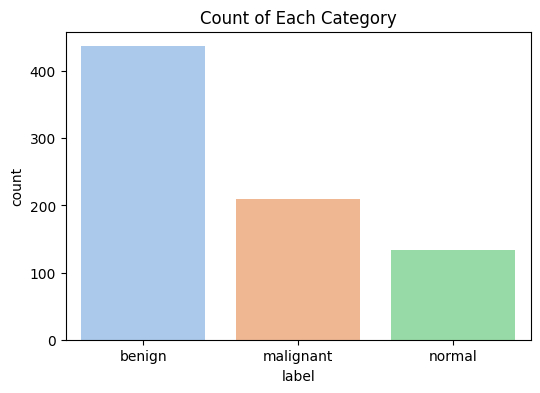

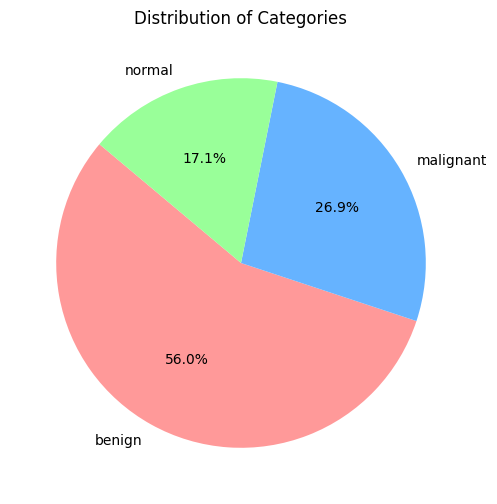

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart of categories
plt.figure(figsize=(6, 4))
sns.countplot(x="label", data=df ,palette='pastel')
plt.title("Count of Each Category")
plt.show()

# Pie chart of categories
df["label"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", startangle=140, figsize=(6, 6),colors=['#ff9999','#66b3ff','#99ff99']
)
plt.title("Distribution of Categories")
plt.ylabel("")  # removes y-axis label
plt.show()


# **Encode Labels & Balance Dataset**

In [10]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

#Encoding the labels into the numbers
encoder = LabelEncoder()
df["Label_num"] = encoder.fit_transform(df["label"])

#Oversample to balance classes
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(df[["image_path"]], df["Label_num"])

#Creating the new balanced dataFrame
df_balanced = pd.DataFrame({"image_path":X["image_path"] , "label_num":y})

print("\nBalanced class counts:")
print(df_balanced["label_num"].value_counts())


Balanced class counts:
label_num
0    437
1    437
2    437
Name: count, dtype: int64


# **Train/Valid/Test Split**

In [14]:
from sklearn.model_selection import train_test_split

df_balanced['label_num'] = df_balanced['label_num'].astype(str)

train_df, temp_df = train_test_split(df_balanced, train_size=0.8, shuffle=True,
                                     stratify=df_balanced['label_num'], random_state=42)

valid_df, test_df = train_test_split(temp_df, test_size=0.5, shuffle=True,
                                     stratify=temp_df['label_num'], random_state=42)

print("Train size:", train_df.shape)
print("Validation size:", valid_df.shape)
print("Test size:", test_df.shape)


Train size: (1048, 2)
Validation size: (131, 2)
Test size: (132, 2)


# **Data Generators**

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,      # rotate images randomly by 20 degrees
    width_shift_range=0.1,  # shift horizontally by 10%
    height_shift_range=0.1, # shift vertically by 10%
    zoom_range=0.1,         # random zoom
    horizontal_flip=True,   # flip images horizontally
    vertical_flip=False,    # vertical flip (usually not for medical images)
    fill_mode='nearest')

ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image_path', y_col='label_num',
                                       target_size=img_size, class_mode='sparse',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image_path', y_col='label_num',
                                       target_size=img_size, class_mode='sparse',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image_path', y_col='label_num',
                                      target_size=img_size, class_mode='sparse',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 1048 validated image filenames belonging to 3 classes.
Found 131 validated image filenames belonging to 3 classes.
Found 132 validated image filenames belonging to 3 classes.


# **Create Xception + Attention Model, Train Model, Plot Accuracy & Loss, Evaluate on Test Set**

In [21]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GaussianNoise, MultiHeadAttention
from tensorflow.keras.optimizers import Adam

def create_model(input_shape=(224, 224, 3), num_classes=3):
    # Input
    inputs = Input(shape=input_shape)

    # Pretrained Xception (without top layers)
    base = Xception(weights='imagenet', include_top=False, input_tensor=inputs)

    # Freeze all layers except last 4
    for layer in base.layers[:-4]:
        layer.trainable = False

    x = base.output

    # Add attention and noise
    x = MultiHeadAttention(num_heads=8, key_dim=x.shape[-1])(x, x)
    x = GaussianNoise(0.25)(x)

    # Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# Create model
model = create_model()

# Compile model
model.compile(optimizer=Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add_12[0][0]    

 Total params: 156,313,643 (596.29 MB)

 Trainable params: 138,614,787 (528.77 MB)

 Non-trainable params: 17,698,856 (67.52 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=5,
                    callbacks=[early_stopping],
                    verbose=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 9s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        44
           1       0.65      0.70      0.67        44
           2       0.83      0.68      0.75        44

    accuracy                           0.71       132
   macro avg       0.72      0.71      0.71       132
weighted avg       0.72      0.71      0.71       132



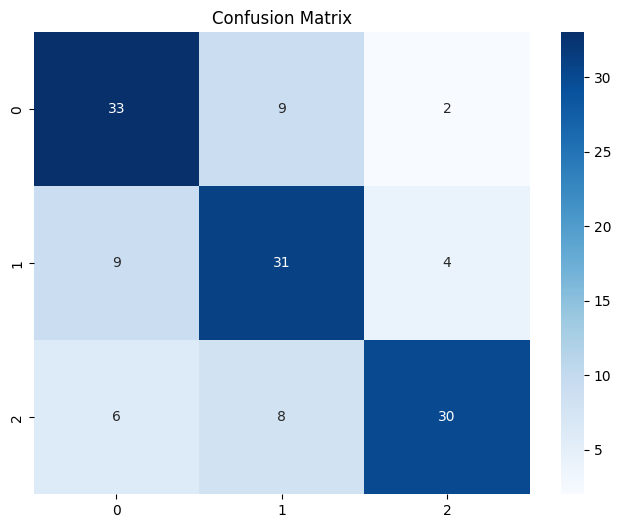

In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# True labels from test generator
y_true = test_gen.classes

# Predictions
y_pred = np.argmax(model.predict(test_gen), axis=1) #argmax finds the index of the largest value in an array

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.show()
